In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def data_preprocess(raw) :
    tmp_stk_list = raw.iloc[8].tolist()
    tmp_stk_list[0] = 'Date'

    data = raw.iloc[13:][::-1]
    data.columns = tmp_stk_list
    data.set_index('Date',inplace =True)
    data = data.T.reset_index().drop_duplicates(['index'], keep='first').set_index('index').T
    data.index = pd.to_datetime(data.index)
    
    #data = data[start:end]
    #data = data.fillna(-1).astype(int).replace(-1, np.nan)
    
    return data

In [3]:
stg_ret = pd.read_excel('배당_수정.xlsx', sheet_name = '배당관련_수익률')
stg_ret = stg_ret.set_index('Date')
tran = pd.read_csv('거래대금.csv')
div_ret = pd.read_csv('배당수익률.csv')
market_cap = pd.read_csv('시가총액.csv')
dps = pd.read_csv('컨센_DPS.csv')
close = pd.read_csv('종가.csv')

In [5]:
tran = data_preprocess(tran)
tran = tran.iloc[1:]
div_ret = data_preprocess(div_ret)
market_cap = data_preprocess(market_cap)
close = data_preprocess(close)
div_ret = div_ret.iloc[1:]

In [6]:
close = close.astype(float)
div_ret = div_ret.astype(float)
div_ret = div_ret * 0.01

In [7]:
stk_list = dps.iloc[5:,1].tolist()

tmp_dps = dps.iloc[5:,2:]
tmp_dps = tmp_dps.T
tmp_dps.columns = stk_list
tmp_dps = tmp_dps.T.reset_index().drop_duplicates(['index'], keep='first').set_index('index').T
tmp_dps.index = ['2021','2020','2019','2018','2017','2016','2015','2014','2013','2012','2011']
tmp_dps = tmp_dps[::-1]
dps = tmp_dps.copy()
dps = dps.astype(float)

In [8]:
screen_date = ['2011-12-26','2012-12-24','2013-12-24','2014-12-24','2015-12-24',
               '2016-12-26','2017-12-22','2018-12-24','2019-12-24','2020-12-24']

In [9]:
year = ['2011','2012','2013','2014','2015','2016','2017','2018','2019','2020']

In [10]:
screen_year_list = []

In [11]:
close_year_list = []

In [12]:
for date in screen_date : 
    mc_screen = market_cap.loc[date][market_cap.loc[date].fillna(0).astype(float) > 300000].dropna().index
    tr_screen = tran[mc_screen].loc[date][tran[mc_screen].loc[date].fillna(0).astype(float) > 5000000000].dropna().index
    screen_year_list.append(tr_screen)
    close_year_list.append(close.loc[date][tr_screen])

In [13]:
consen_div_year_list = []

In [14]:
for i, date in enumerate(year) :
    print(date)
    consen_div_year_list.append((dps[screen_year_list[i]].loc[date] / close_year_list[i]).dropna().sort_values()[::-1])

2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


In [17]:
def backtest(stg_ret_, consen_div_year_list_,div_ret_, num, stk_num) :
    str_ret_ = stg_ret_.iloc[num][consen_div_year_list_[num][:stk_num].index].dropna()
    real_div_ret_ = div_ret_.iloc[num][stg_ret_.iloc[num][consen_div_year_list_[num][:stk_num].index].dropna().index]
    return str_ret_, real_div_ret_

In [18]:
# 증권사 수수료 0.015% (매수 매도 각각)
# 거래세 0.3%
# 총합 0.03% + 0.3%
# 0.0033

In [19]:
# 증권사 수수료 1% (매수 매도 각각)
# 거래세 3%
# 총합 2% + 0.3%
# 0.0033

In [20]:
# 100원에 샀다가 110원에 팔았을 때 수수료 감안 수익률
# (110 - 100) /100 -> 10%
# 110 * 1% = 1.1
# 100 * 1% = 1
# 100 * 3% = 3
# 수수료 및 세금: 5.1%
# 10% - 5.1%

In [21]:
bt_str_ret_list = []
bt_real_div_list = []

for i,year_ in zip(range(10),year) :
    bt_str_ret, bt_real_div_ret = backtest(stg_ret, consen_div_year_list,div_ret, i, 50)
    # 수수료 반영
    bt_str_ret = bt_str_ret.map(lambda x : x - 0.0033)
    bt_real_div_ret = bt_real_div_ret.map(lambda x : x - x * 0.154)
    print('--------------------')
    print(year_)
    print(bt_str_ret.mean() * -1)
    print(bt_real_div_ret.mean())
    bt_str_ret_list.append(bt_str_ret.mean() * -1)
    bt_real_div_list.append(bt_real_div_ret.mean())

--------------------
2011
0.012294947306335034
0.022059449999999998
--------------------
2012
0.009226441883531625
0.017956841860465114
--------------------
2013
0.008228913502885092
0.01589693023255814
--------------------
2014
0.014427619541022382
0.01893536
--------------------
2015
0.015823943508795606
0.02468012727272727
--------------------
2016
0.020669848318498944
0.0244370625
--------------------
2017
0.01936981438969782
0.02330819999999999
--------------------
2018
0.01350438786998099
0.027294534782608685
--------------------
2019
0.024394826053045313
0.026112048979591823
--------------------
2020
0.02324460739204792
0.032977799999999995


In [23]:
visual = pd.DataFrame()
visual['거래수익률'] = bt_str_ret_list
visual['실제배당수익률'] = bt_real_div_list
visual['year'] = year
visual = visual.set_index('year')

In [28]:
visual

,거래수익률,실제배당수익률
year,,
2011,0.012295,0.022059
2012,0.009226,0.017957
2013,0.008229,0.015897
2014,0.014428,0.018935
2015,0.015824,0.024680
2016,0.020670,0.024437
2017,0.019370,0.023308
2018,0.013504,0.027295
2019,0.024395,0.026112


<AxesSubplot:xlabel='year'>

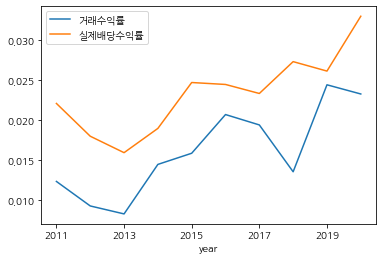

In [38]:
visual.plot()

In [30]:
alpha = pd.DataFrame()
alpha['Alpha'] = visual['실제배당수익률'] - visual['거래수익률']

In [32]:
alpha

,Alpha
year,
2011,0.009765
2012,0.008730
2013,0.007668
2014,0.004508
2015,0.008856
2016,0.003767
2017,0.003938
2018,0.013790
2019,0.001717


<AxesSubplot:xlabel='year'>

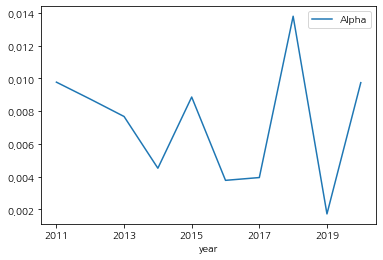

In [39]:
alpha.plot()